# Fit the broadband noise in 1ES 1927+654 with both a Power-Law and a Lorentzian centered at 0

This code runs MCMCs to fit the data with a $\chi^2$ likelihood. These MCMCs are then used for simulating data and comparing to fits with an additional Lorentzian for the QPO.

In [1]:
# load packages
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.fft
import os
import astropy.stats as st
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, NullFormatter
from matplotlib import ticker
import json
import glob
# from redshift get d_L
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
# emcee stuff
import multiprocessing as mp
# from multiprocessing import Pool
import emcee
import corner
from scipy.stats import spearmanr, linregress, binned_statistic, chi2
import pylag
from joblib import Parallel, delayed

from timing import *

# set up plotting defaults
plt.rc('font', family='sans')
params = {
   'axes.labelsize': 45,
   'axes.linewidth': 3,
   'legend.fontsize': 30,
   'legend.frameon': True,
   'legend.fancybox': False,
   'legend.framealpha': 0.8,
   'legend.edgecolor': 'k',
   'lines.linewidth': 2,
   'font.size': 40,
   'font.weight': 'normal',
   'xtick.direction': 'in',
   'xtick.labelsize': 35,
   'xtick.color':'k',
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 18,
   'xtick.major.width': 2,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 10,
   'xtick.minor.size': 9,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 2,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 35,
   'ytick.left': True,
   'ytick.right': True,
   'ytick.major.pad': 10,
   'ytick.major.size': 18,
   'ytick.major.width': 2,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 9,
   'ytick.minor.visible': True,
   'ytick.minor.width': 2,
   'text.usetex': False,
   'figure.figsize': [10,10],
   'savefig.dpi': 500,
   }
plt.rcParams.update(params)

fig_path = '../figures/'
data_path = '../data/lightcurves/'
mcmc_path = 'broadband_mcmcs/'

/Users/megan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Single Observations

This notebook fits the broadband noise of various XMM-Newton PSDs and performs simulations using the methodology of Timmer & Koenig (1995) to estimate the significance. Below functions are set up to run fits to single observations (with power-law and lorentzian broadband models). To fit the data we use the Bayesian set up defined in Vaughan et al. (2010), with the $\chi^2$ likelihood for fitting the unbinned PSDs. This is required for many AGN PSDs because we are in a regime where there are too few frequency bins to bin up the PSD to Gaussian noise.

### Functions to calculate Fvar, compute some key values from the light curve

In [2]:
# find the fractional rms variability
def calculate_fvar(lightcurve, errors):
    """
    Calculate the fractional variability (Fvar) of a light curve.

    Parameters:
    - lightcurve: array-like, the light curve data (e.g., count rates).
    - errors: array-like, the errors associated with each point in the light curve.

    Returns:
    - Fvar: the fractional variability.
    - Fvar_err: the error in the fractional variability.
    """

    # Mean of the light curve
    mean_lc = np.mean(lightcurve)

    # Square of the errors
    squared_errors = np.square(errors)

    # Excess variance
    excess_variance = np.sum((lightcurve - mean_lc)**2 - squared_errors) / (len(lightcurve) * mean_lc**2)

    # Error on the excess variance
    err_excess_variance = np.sqrt(np.sum(squared_errors**2) / (len(lightcurve)**2 * mean_lc**4))

    # Fractional variability
    Fvar = np.sqrt(excess_variance)

    # Error on the fractional variability
    Fvar_err = 0.5 * Fvar**-1 * err_excess_variance

    return Fvar, Fvar_err

In [3]:
def get_key_values(obs, data_path, emin, emax, tbin=20):

    lc_file = "PN_"+obs+"_"+str(emin)+"-"+str(emax)+"_"+str(tbin)+"s.lc"
    hdu = fits.open(data_path+lc_file)
    data = hdu[1].data
    data = data[~np.isnan(data['RATE'])]
    time = data['TIME']-data['TIME'][0]
    rate = data['RATE']
    err = data['ERROR']

    N = len(time)
    mean = np.mean(rate)
    rms = np.sqrt(np.sum((rate - mean)**2) / (N - 1))

    return N, mean, rms

### Bayesian functions to run likelihood estimation and MCMC

In [4]:
# first we need to fit the continuum model -- then we will use this to generate simulated light curves
def log_likelihood(theta, f, y, model):
    if model == 'powerlaw':
        N0, b, c = theta
        model_y = powerlaw(f, N0, b, c)
    elif model == 'lorentzian':
        R, delta, c = theta
        model_y = lorentzian(f, R, delta, c)
    return np.sum((y / model_y) + np.log(model_y)) # note that this is really the negative log likelihood (i.e. minimize this fn for MLE)

def log_prior(theta, model):
    if model == 'powerlaw':
        N0, b, c = theta
        if 0 < N0 < 1e10 and -5 < b < 5 and 0 < c < 100:
            return 0.0
    elif model == 'lorentzian':
        R, delta, c = theta
        if 0 < R < 1e2 and 1e-10 < delta < 1e1 and 1e-10 < c < 100:
            return 0.0
    return -np.inf

def log_probability(theta, f, y, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood(theta, f, y, model)

### Run maximum likelihood and initialize an MCMC based on that fit

In [5]:
def MLE_and_MCMC(obs, data_path, emin, emax, tbin=20, n=0, nwalkers=32, use_model='all', nsteps=5500, nburn=500):
    # you should not be changing n = 0 to anything else!

    # run the initial fit
    _, _, _, freq, power, _, _, f_min, f_max, _, _ = make_psd(obs, data_path, emin, emax, tbin, 0)
    grid = np.linspace(f_min, f_max, 1000)

    # first maximize likelihood - power law
    if use_model == 'powerlaw' or use_model == 'all':
        ndim_pl = 3
        initial_guess_pl = [1e-3, 2, 2]
        result_pl = opt.minimize(log_likelihood, initial_guess_pl, args=(freq, power, 'powerlaw'),
                                bounds=((1e-8,1e4),(-2,2),(1e-2,1e2)))
        maxlike_pl = result_pl.x
        p0_pl = maxlike_pl * (1 + 1e-3 * np.random.randn(nwalkers, ndim_pl))

    # first maximize likelihood - broken power law
    if use_model == 'lorentzian' or use_model == 'all':
        ndim_lor = 3
        initial_guess_lor = [5e-1, 1e-3, 1]
        result_lor = opt.minimize(log_likelihood, initial_guess_lor, args=(freq, power, 'lorentzian'),
                                  bounds=((0,100),(1e-6,1),(1e-4,100)))
        maxlike_lor = result_lor.x
        p0_lor = maxlike_lor * (1 + 1e-3 * np.random.randn(nwalkers, ndim_lor))

    # grab n_rand samples and pick out the median fit
    n_rand = 10000
    if use_model == 'powerlaw' or use_model == 'all':

        fname = mcmc_path+'broadband_'+obs+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_pl = backend.get_chain(discard=nburn, flat=True)
            Dmin_H0 = min(-backend.get_log_prob(discard=nburn, flat=True))
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_pl)
            sampler_pl = emcee.EnsembleSampler(nwalkers, ndim_pl, log_probability, args=(freq, power, 'powerlaw'), backend=backend)
            sampler_pl.run_mcmc(p0_pl, nsteps, progress=True)
            samples_pl = sampler_pl.get_chain(discard=nburn, flat=True)
            Dmin_H0 = min(-sampler_pl.get_log_prob(discard=nburn, flat=True))

        lab = [r"$\log N_0$", r"$\alpha$", r"$c$"]
        fig = corner.corner(samples_pl, labels=lab, truths=maxlike_pl, figsize=(18,18), labelpad=1)

        rand_ints = np.random.randint(low=0, high=len(samples_pl[:,0]), size=n_rand)
        fit_pl = np.zeros((len(grid),n_rand))
        # also compute the fit a the frequencies of the PSD
        fit_binned_pl = np.zeros((len(freq),n_rand))
        for i in range(n_rand):
            j = rand_ints[i]
            use_N0, use_b, use_c = samples_pl[j,:]
            fit_pl[:,i] = powerlaw(grid, use_N0, use_b, use_c)
            fit_binned_pl[:,i] = powerlaw(freq, use_N0, use_b, use_c)
        med_fit_pl = np.median(fit_pl, axis=1)
        med_fit_binned_pl = np.median(fit_binned_pl, axis=1)

        # find T_R
        Rhat_pl = 2 * power / med_fit_binned_pl 
        Rhat_max_pl = np.max(Rhat_pl)
        QPO_freq_pl = freq[np.argmax(Rhat_pl)]

        # find T_SSE
        SSE_pl = np.sum(((power - med_fit_binned_pl) / med_fit_binned_pl)**2)
        
        print('R (power-law): ', Rhat_max_pl)
        print('QPO freq. (power-law): ', QPO_freq_pl)
        print('SSE (power-law): ', SSE_pl)

    if use_model == 'lorentzian' or use_model == 'all':

        fname = mcmc_path+'broadband_'+obs+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_lor = backend.get_chain(discard=nburn, flat=True)
            Dmin_H2 = min(-backend.get_log_prob(discard=nburn, flat=True)) 
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_lor)
            sampler_lor = emcee.EnsembleSampler(nwalkers, ndim_lor, log_probability, args=(freq, power, 'lorentzian'), backend=backend)
            sampler_lor.run_mcmc(p0_lor, nsteps, progress=True)
            samples_lor = sampler_lor.get_chain(discard=nburn, flat=True)
            Dmin_H2 = min(-sampler_lor.get_log_prob(discard=nburn, flat=True)) 

        lab = [r"$R$", r"$\Delta$", r"$c$"]
        fig = corner.corner(samples_lor, labels=lab, truths=maxlike_lor, figsize=(18,18), labelpad=1)

        rand_ints = np.random.randint(low=0, high=len(samples_lor[:,0]), size=n_rand)
        fit_lor = np.zeros((len(grid),n_rand))
        # also compute the fit a the frequencies of the PSD
        fit_binned_lor = np.zeros((len(freq),n_rand))
        for i in range(n_rand):
            j = rand_ints[i]
            use_R, use_delta, use_c = samples_lor[j,:]
            fit_lor[:,i] = lorentzian(grid, use_R, use_delta, use_c)
            fit_binned_lor[:,i] = lorentzian(freq, use_R, use_delta, use_c)
        med_fit_lor = np.median(fit_lor, axis=1)
        med_fit_binned_lor = np.median(fit_binned_lor, axis=1)

        # find T_R
        Rhat_lor = 2 * power / med_fit_binned_lor 
        Rhat_max_lor = np.max(Rhat_lor)
        QPO_freq_lor = freq[np.argmax(Rhat_lor)]

        # find T_SSE
        SSE_lor = np.sum(((power - med_fit_binned_lor) / med_fit_binned_lor)**2)

        print('R (lorentzian): ', Rhat_max_lor)
        print('QPO freq. (lorentzian): ', QPO_freq_lor)
        print('SSE (lorentzian): ', SSE_lor)

    # plot 
    if use_model == 'all':
        fig, axs = plt.subplots(figsize=(20,22), nrows=3, gridspec_kw={'hspace':0, 'height_ratios':[1,0.3,0.3]})
        ax = axs[0]
        ax.step(freq, power, color='k', lw=2, where='mid')
        ax.plot(grid, med_fit_pl, color='slateblue', lw=5, ls='--', label='Median Power-Law (MCMC)')
        ax.plot(grid, med_fit_lor, color='xkcd:peach', lw=5, ls='--', label='Median Lorentzian(MCMC)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Periodogram')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(8e-2,3e2)
        ax = axs[1]
        ax.axhline(1, color='slateblue', ls='--', lw=5)
        ax.step(freq, power / med_fit_binned_pl, color='k', lw=2, where='mid')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('D / M')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(3e-2,2e1)
        ax = axs[2]
        ax.axhline(1, color='xkcd:peach', ls='--', lw=5)
        ax.step(freq, power / med_fit_binned_lor, color='k', lw=2, where='mid')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('D / M')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(3e-2,2e1)

    if use_model == 'powerlaw':
        fig, axs = plt.subplots(figsize=(20,14), nrows=2, gridspec_kw={'hspace':0, 'height_ratios':[1,0.3]})
        ax = axs[0]
        ax.step(freq, power, color='k', lw=2, where='mid')
        ax.plot(grid, med_fit_pl, color='slateblue', lw=5, ls='--', label='Maximum Likelihood Power-Law')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Periodogram')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(8e-2,3e2)
        ax = axs[1]
        ax.axhline(1, color='slateblue', ls='--', lw=5)
        ax.step(freq, power / med_fit_binned_pl, color='k', lw=2, where='mid')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('D / M')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(3e-2,2e1)

    if use_model == 'lorentzian':
        fig, axs = plt.subplots(figsize=(20,14), nrows=2, gridspec_kw={'hspace':0, 'height_ratios':[1,0.3]})
        ax = axs[0]
        ax.step(freq, power, color='k', lw=2, where='mid')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Periodogram')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(8e-2,3e2)
        ax = axs[1]
        ax.axhline(1, color='xkcd:seafoam green', ls='--', lw=5)
        ax.step(freq, power / med_fit_binned_lor, color='k', lw=2, where='mid')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('D / M')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(3e-2,2e1)

    axs[0].legend(fontsize=24, loc='lower left')

    # for LRT + saving all the samples
    if use_model == 'all':

        # power law values to save
        save_N0_pl = samples_pl[:,0]
        save_b_pl = samples_pl[:,1]
        save_c_pl = samples_pl[:,2]

        # lorentzian values to save
        save_R_lor = samples_lor[:,0]
        save_delta_lor = samples_lor[:,1]
        save_c_lor = samples_lor[:,2]

        return save_N0_pl, save_b_pl, save_c_pl, Rhat_max_pl, QPO_freq_pl, SSE_pl, save_R_lor, save_delta_lor, save_c_lor, Rhat_max_lor, QPO_freq_lor, SSE_lor

    
    elif use_model == 'powerlaw':
        return Rhat_max_pl, QPO_freq_pl, SSE_pl
    elif use_model == 'lorentzian':
        return Rhat_max_lor, QPO_freq_lor, SSE_lor

heads up -- your data is not continuous and you are linearly interpolating the gaps. make sure that these gaps are not too long.
R (power-law):  29.841073946908153
QPO freq. (power-law):  0.0017279411764705881
SSE (power-law):  1192.9011467551993
R (lorentzian):  22.826051311661875
QPO freq. (lorentzian):  0.0017279411764705881
SSE (lorentzian):  969.228458629629
R (power-law):  21.764676393140743
QPO freq. (power-law):  0.0022575869726128794
SSE (power-law):  915.2848511776475
R (lorentzian):  17.31358839082749
QPO freq. (lorentzian):  0.0022575869726128794
SSE (lorentzian):  783.2757144212646
R (power-law):  28.951031876211704
QPO freq. (power-law):  0.0023097826086956523
SSE (power-law):  578.0484147990031
R (lorentzian):  23.669795637963613
QPO freq. (lorentzian):  0.0023097826086956523
SSE (lorentzian):  492.4214882926102
R (power-law):  13.074763589711623
QPO freq. (power-law):  0.0024390243902439024
SSE (power-law):  494.01570719074726
R (lorentzian):  11.698331499822764
QPO fre

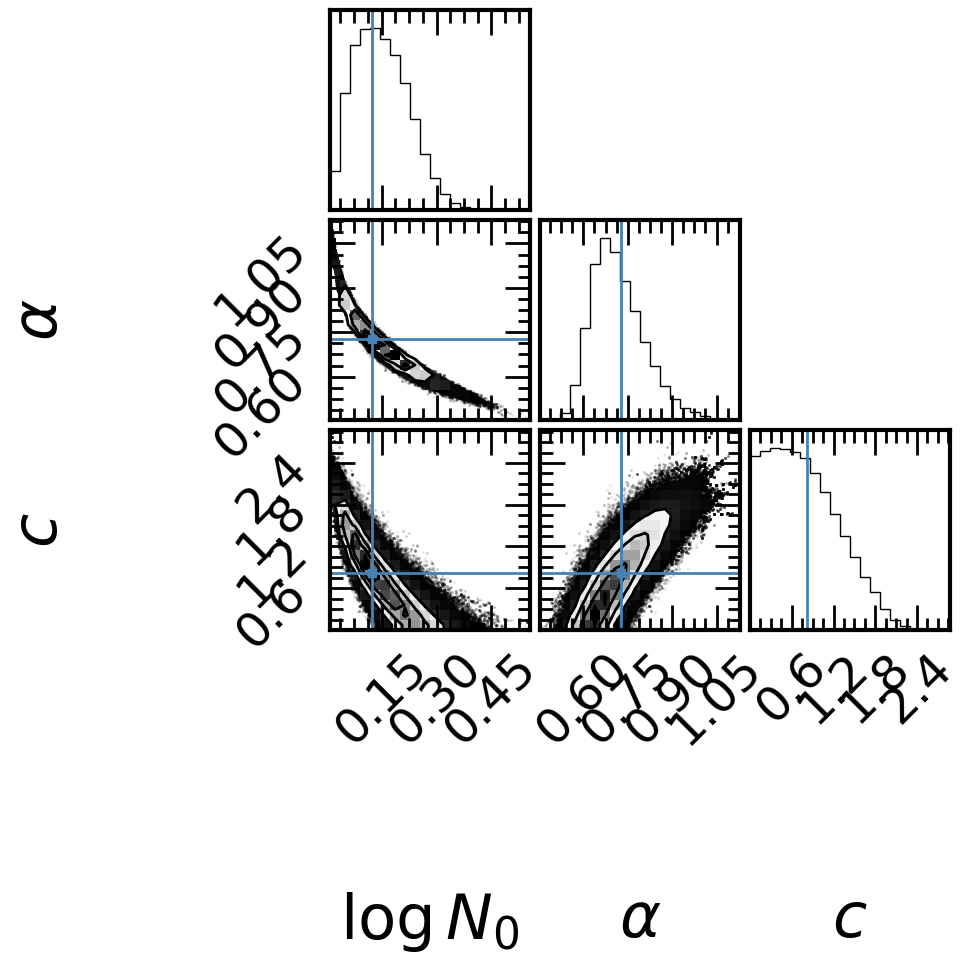

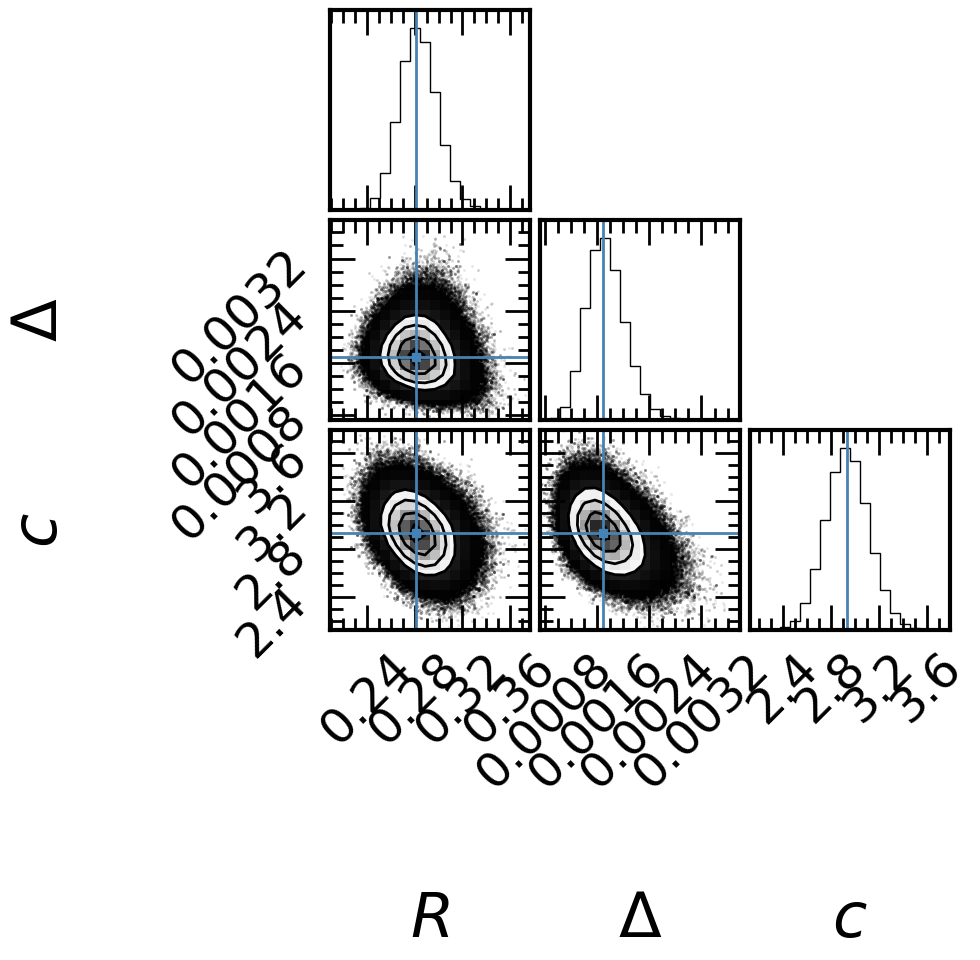

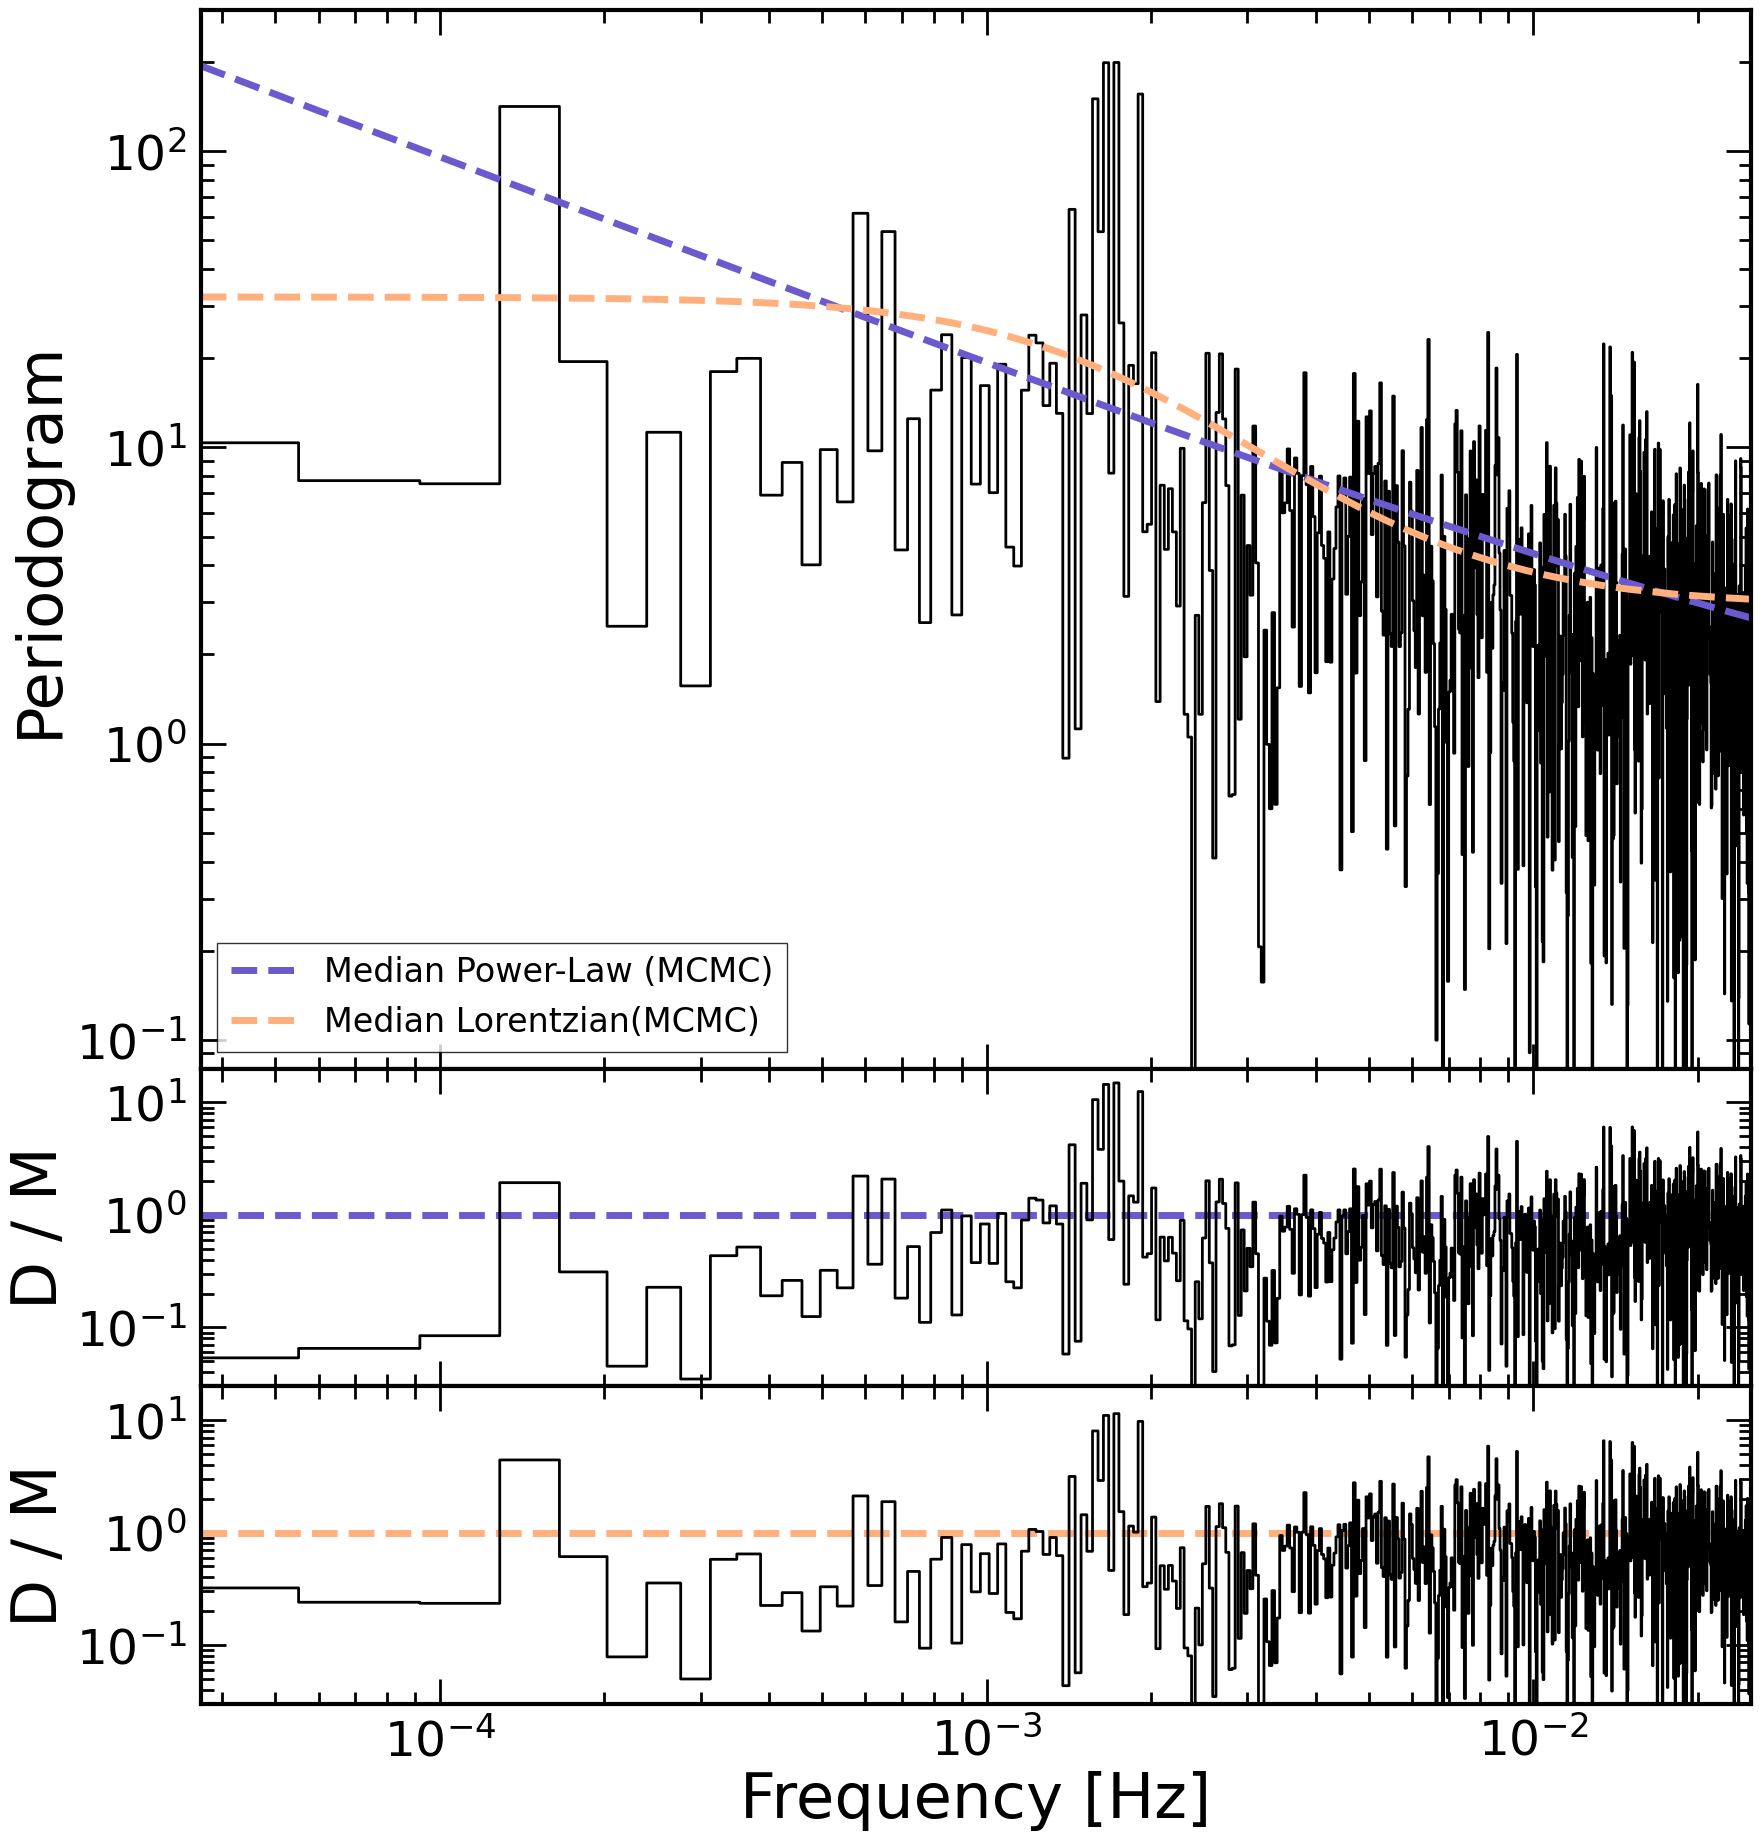

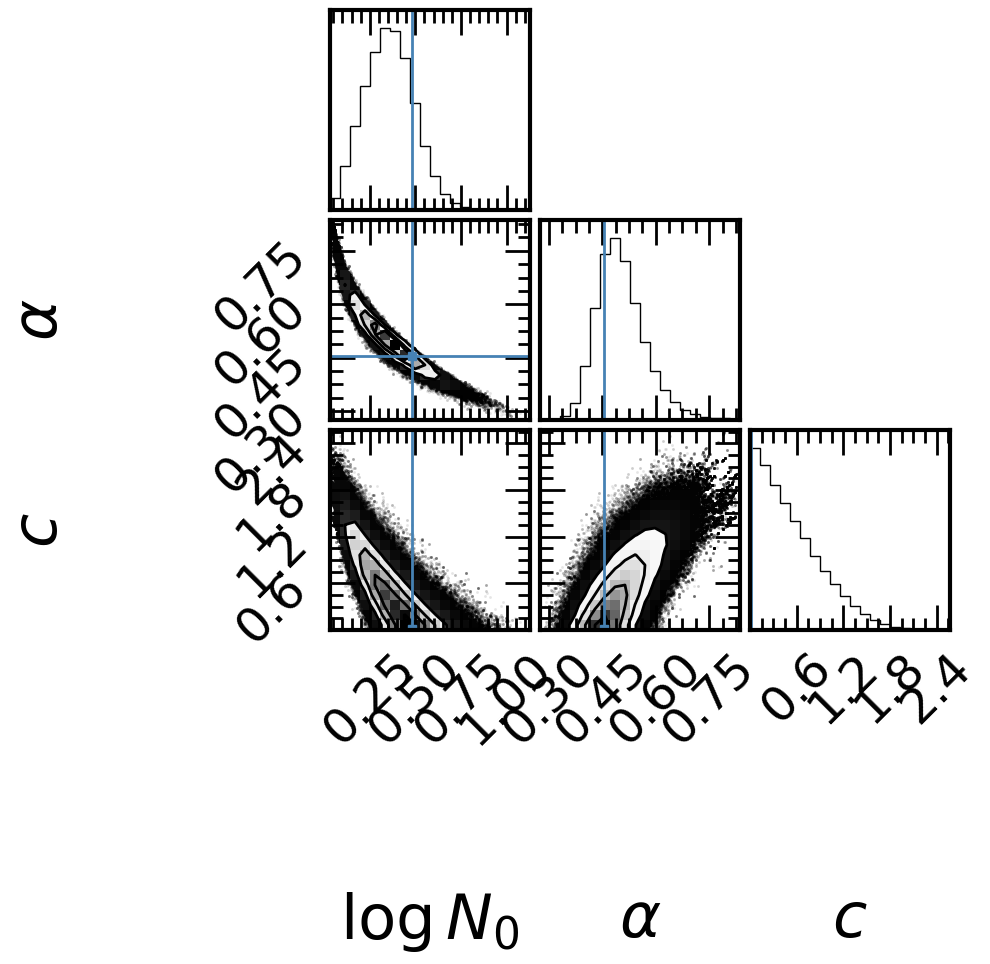

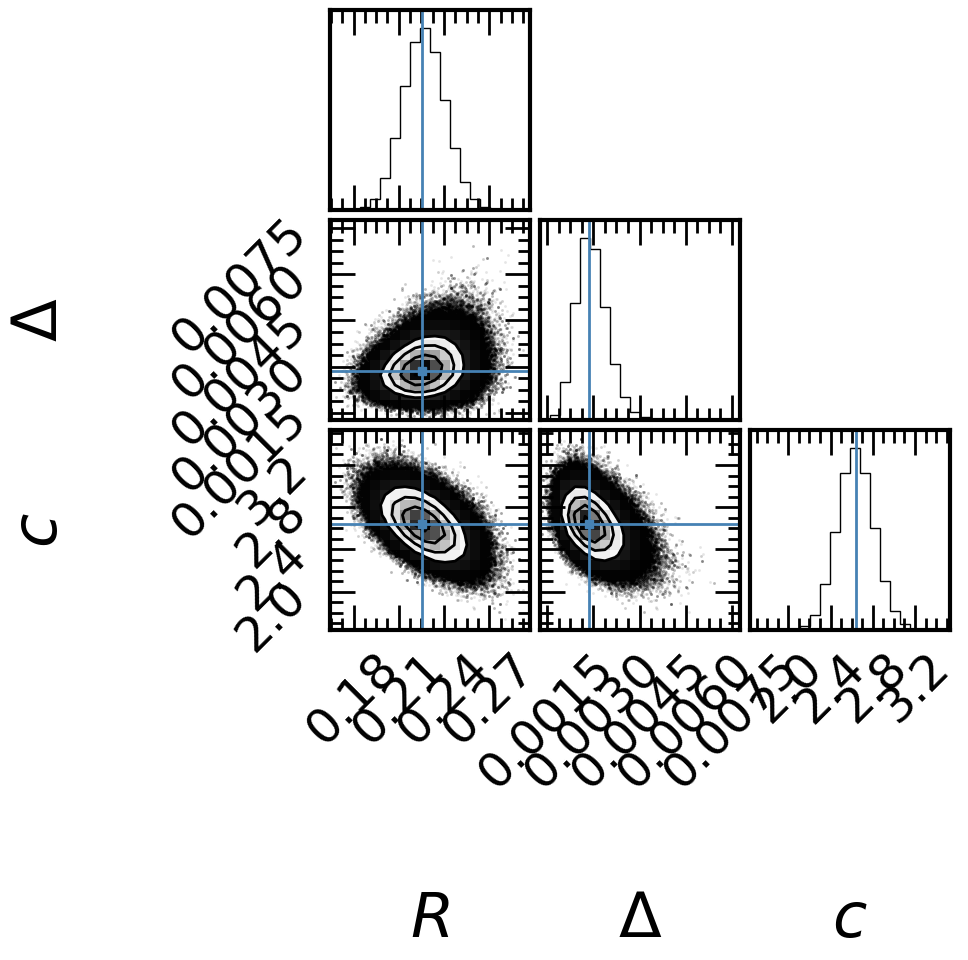

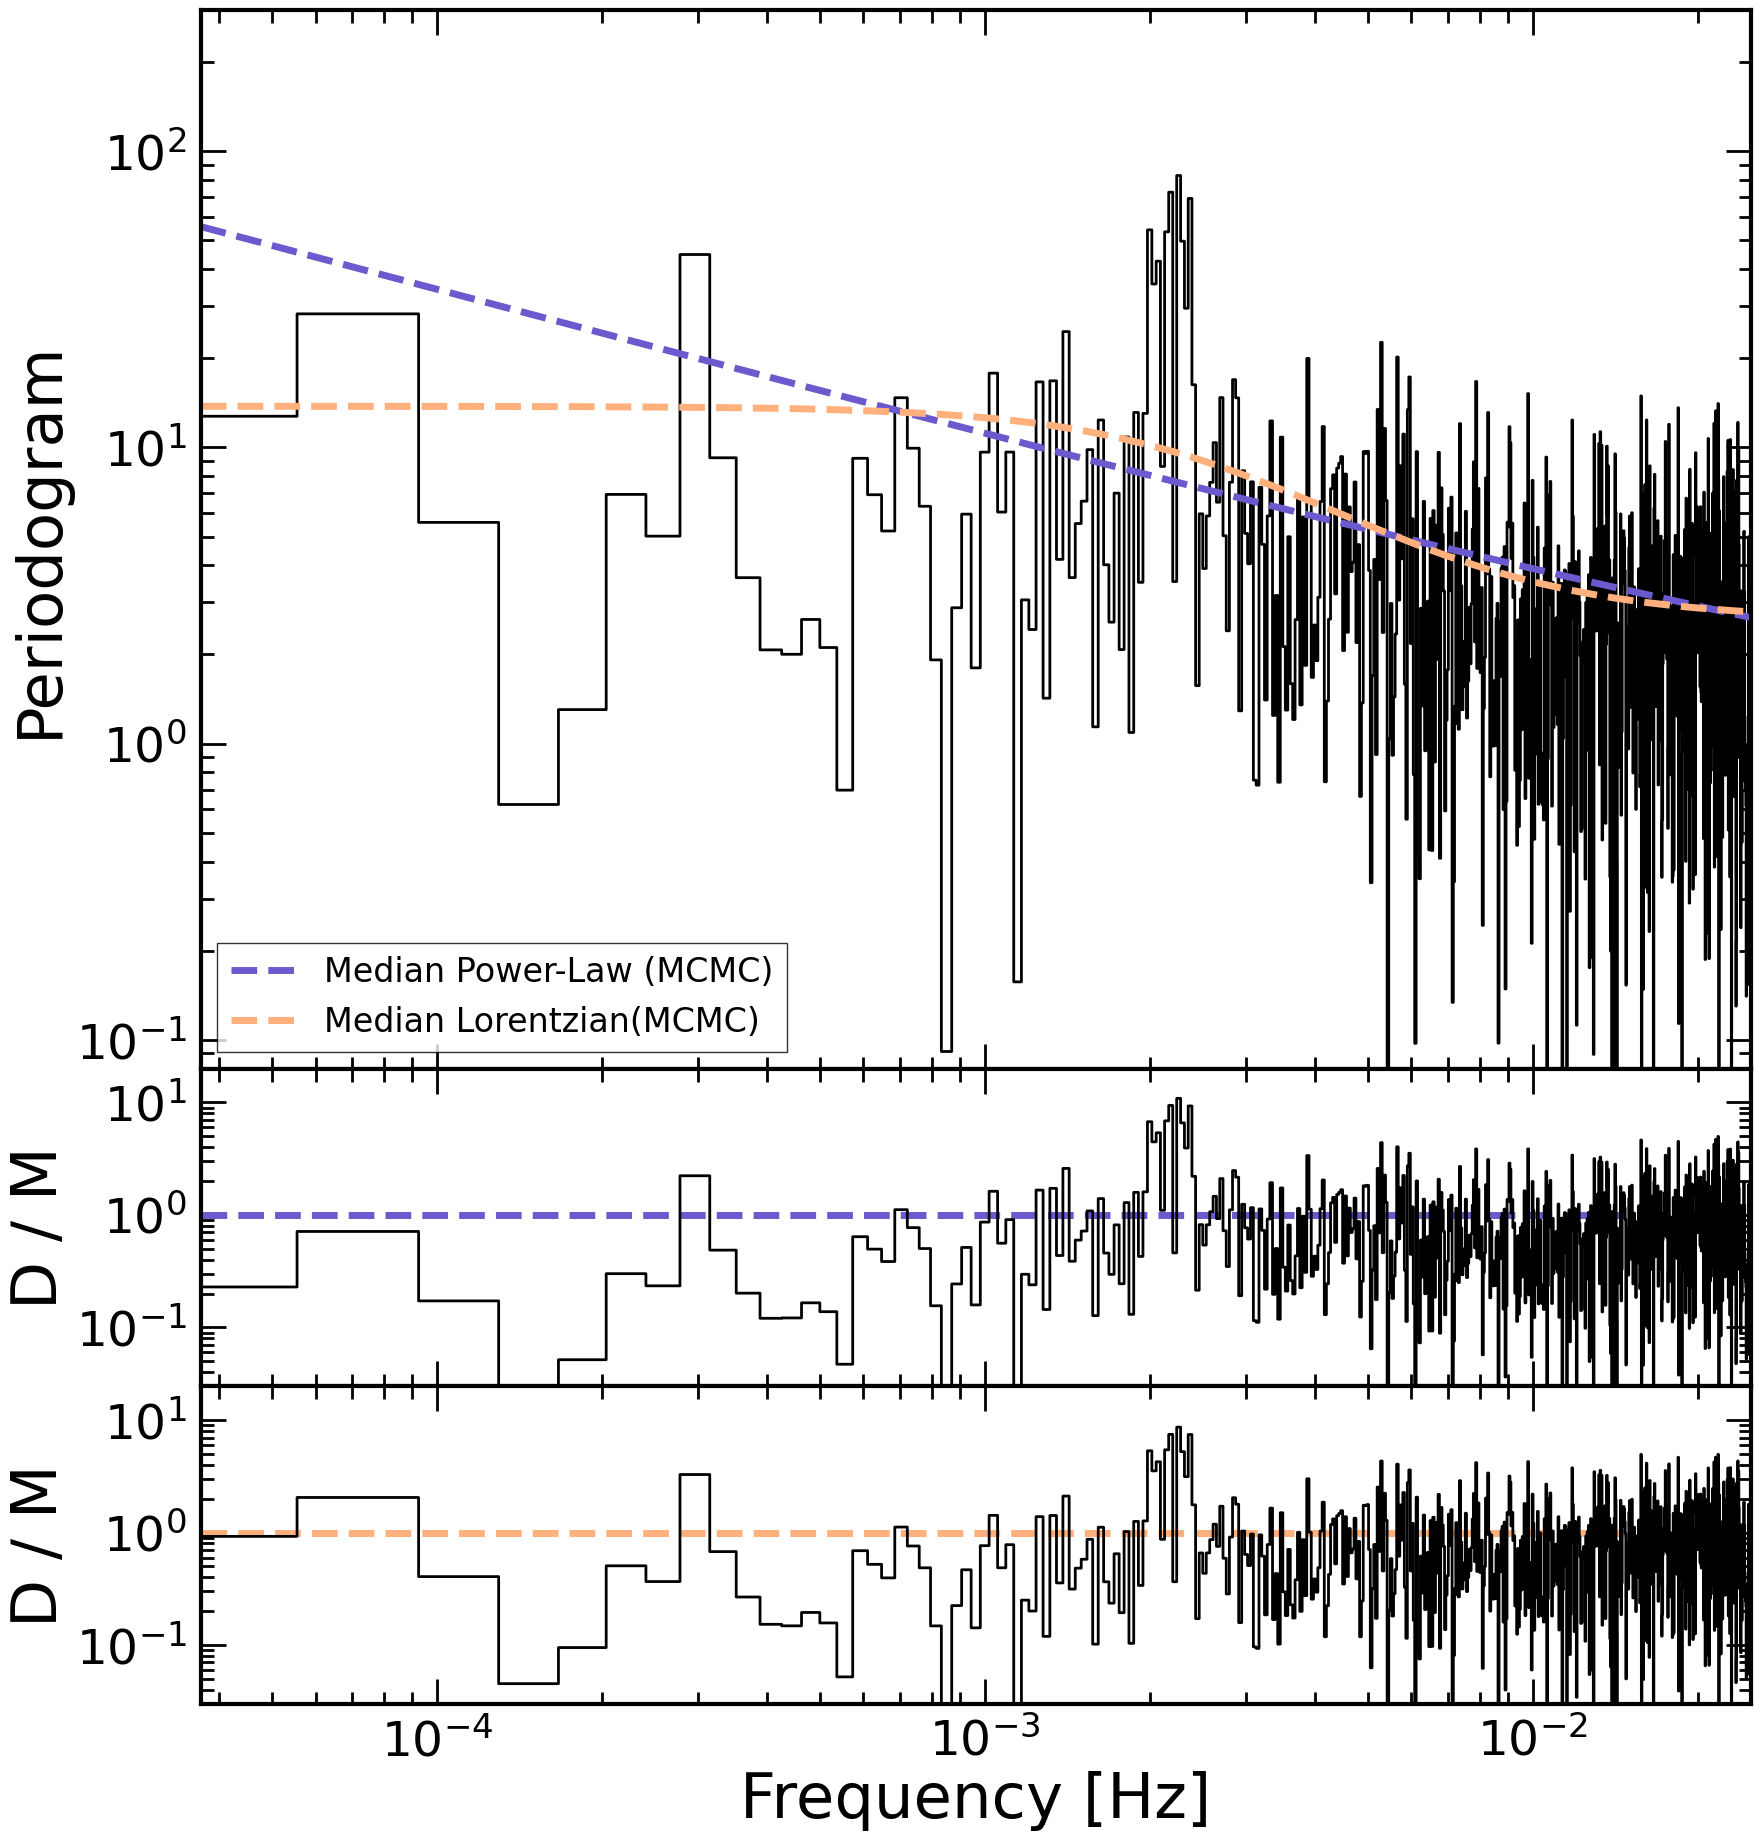

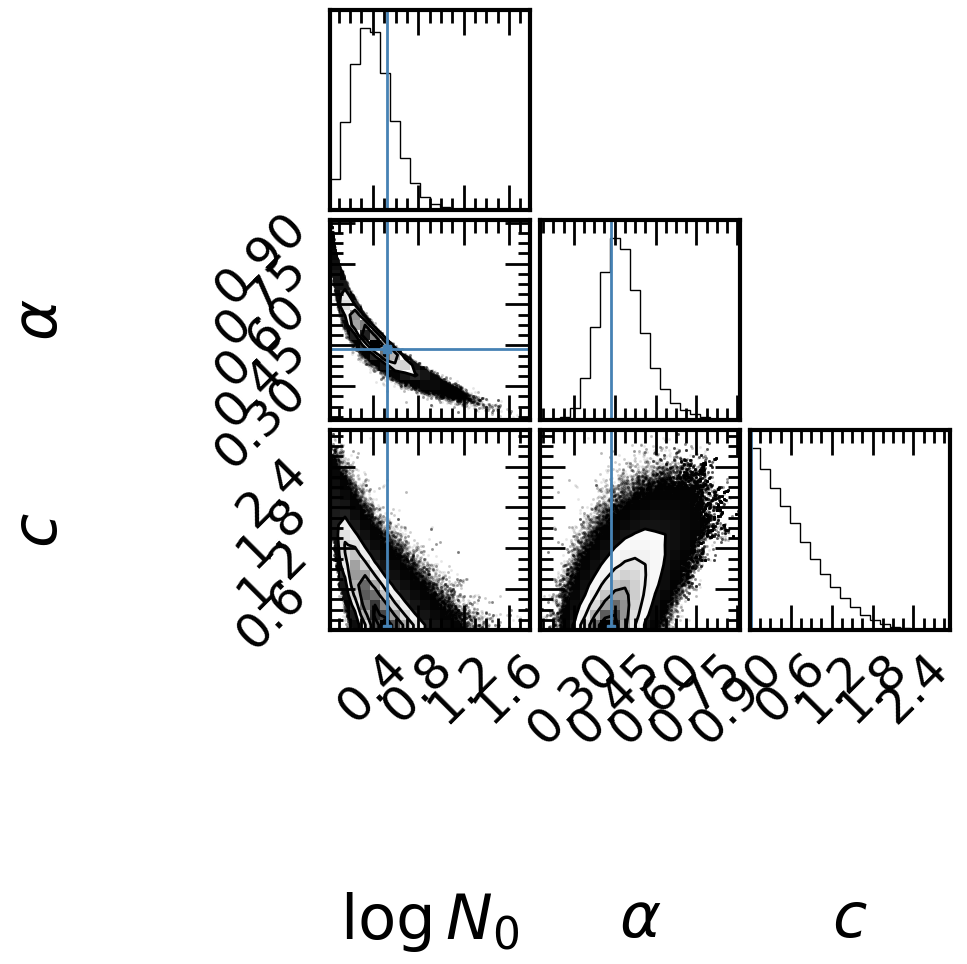

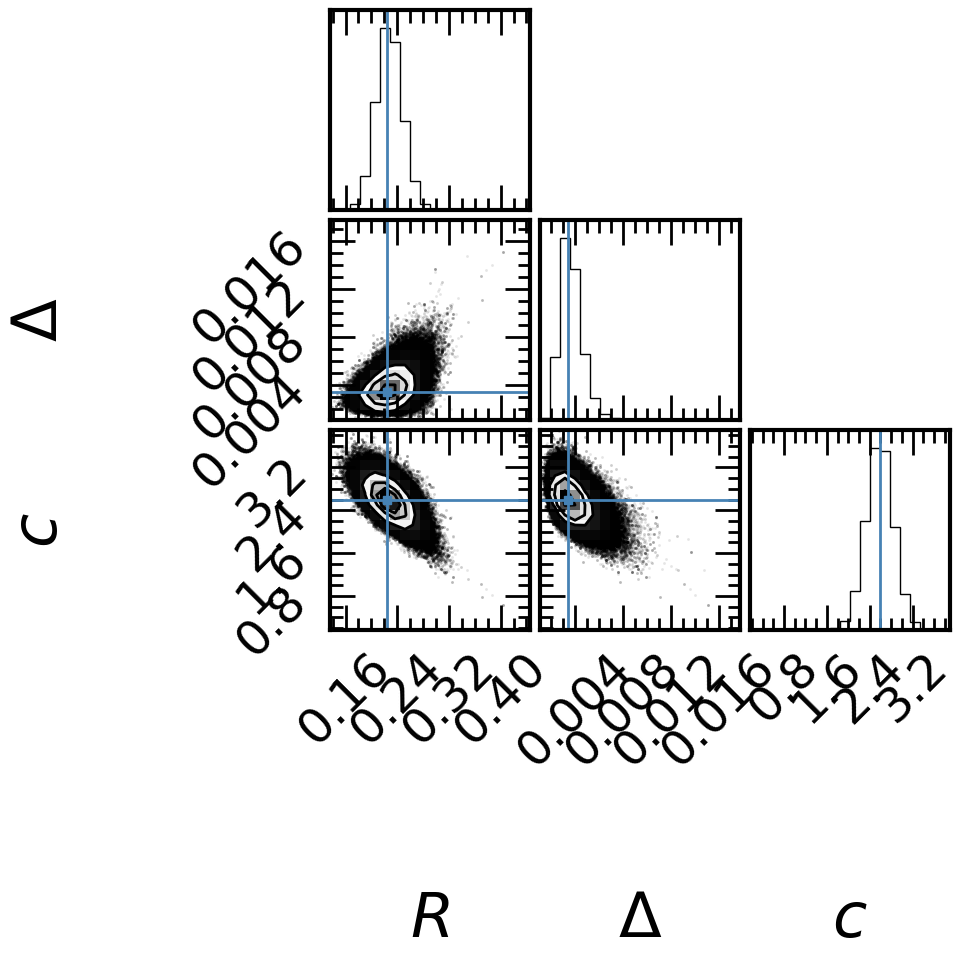

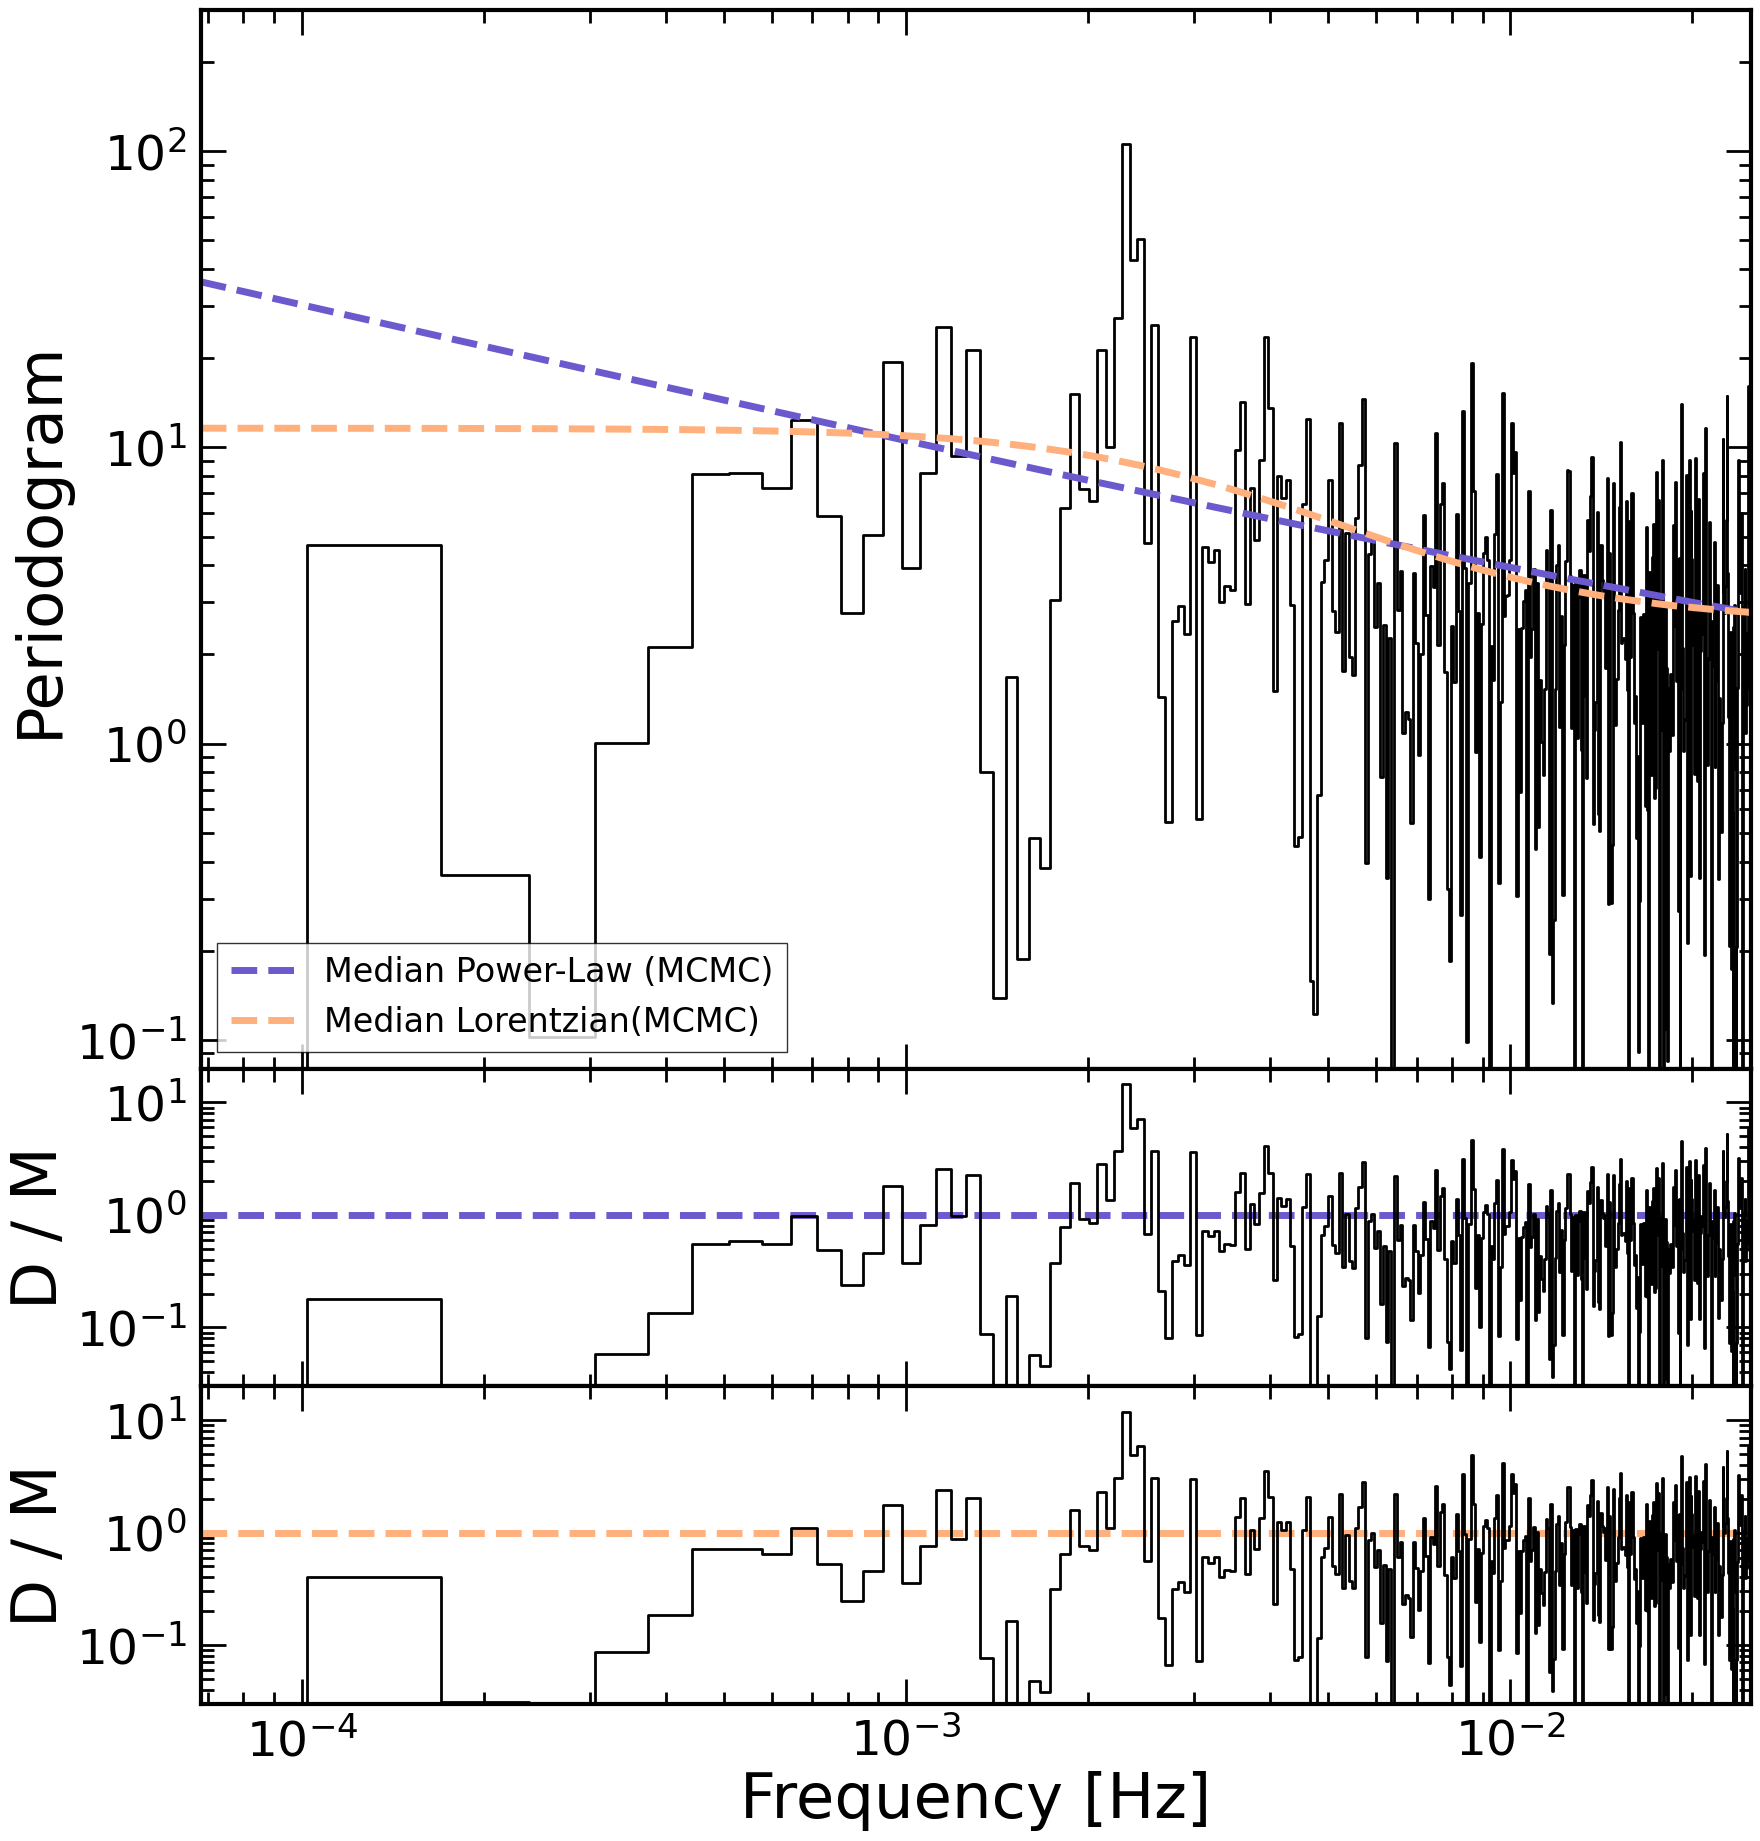

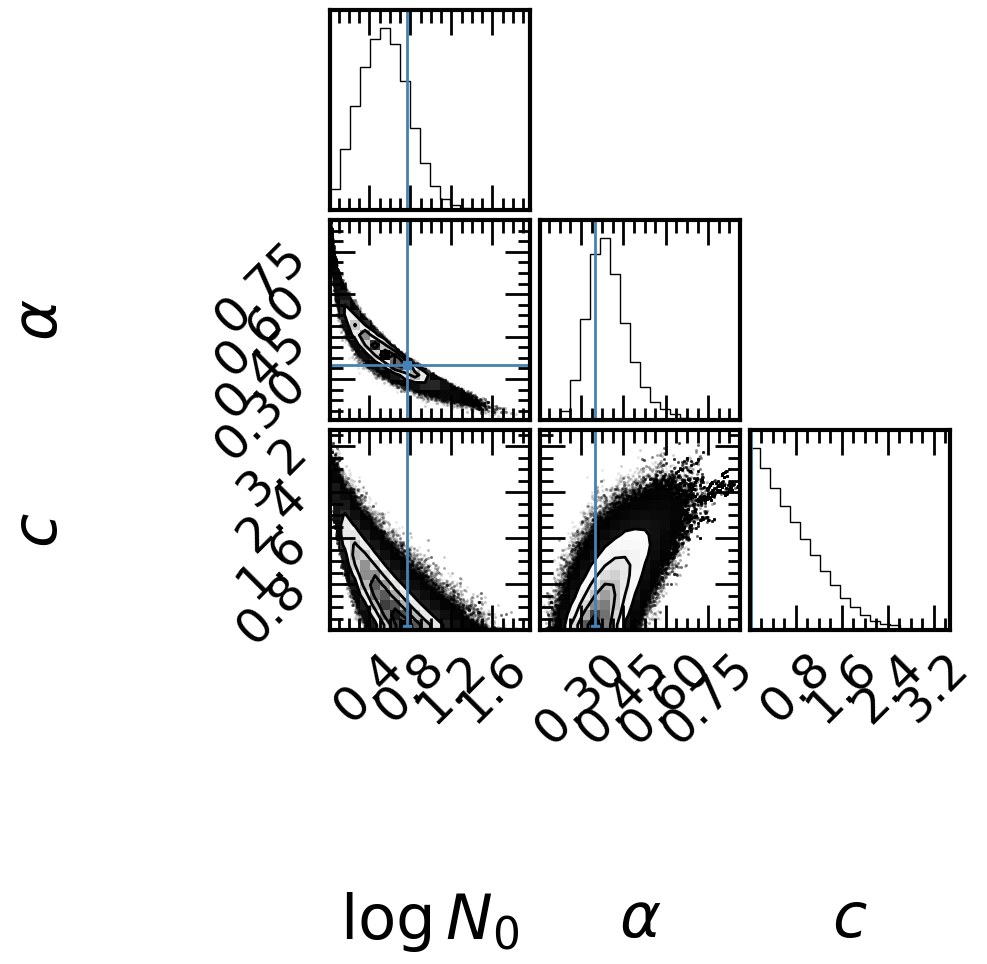

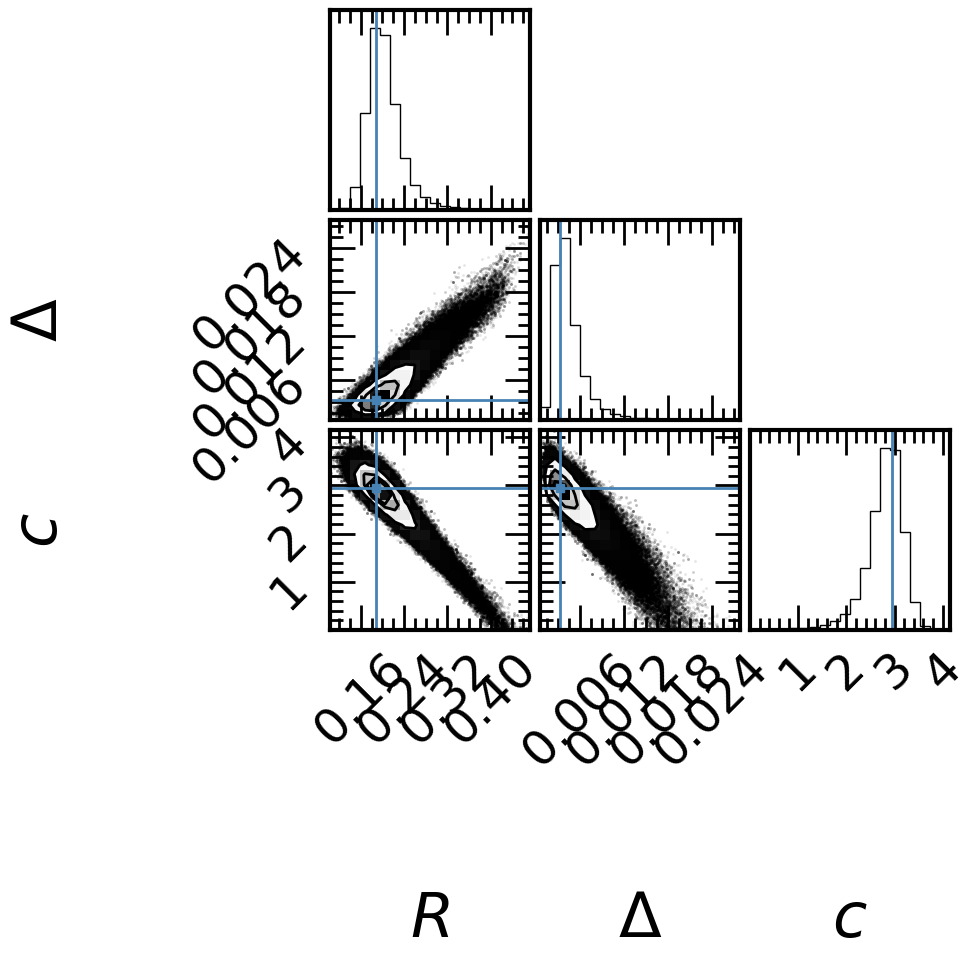

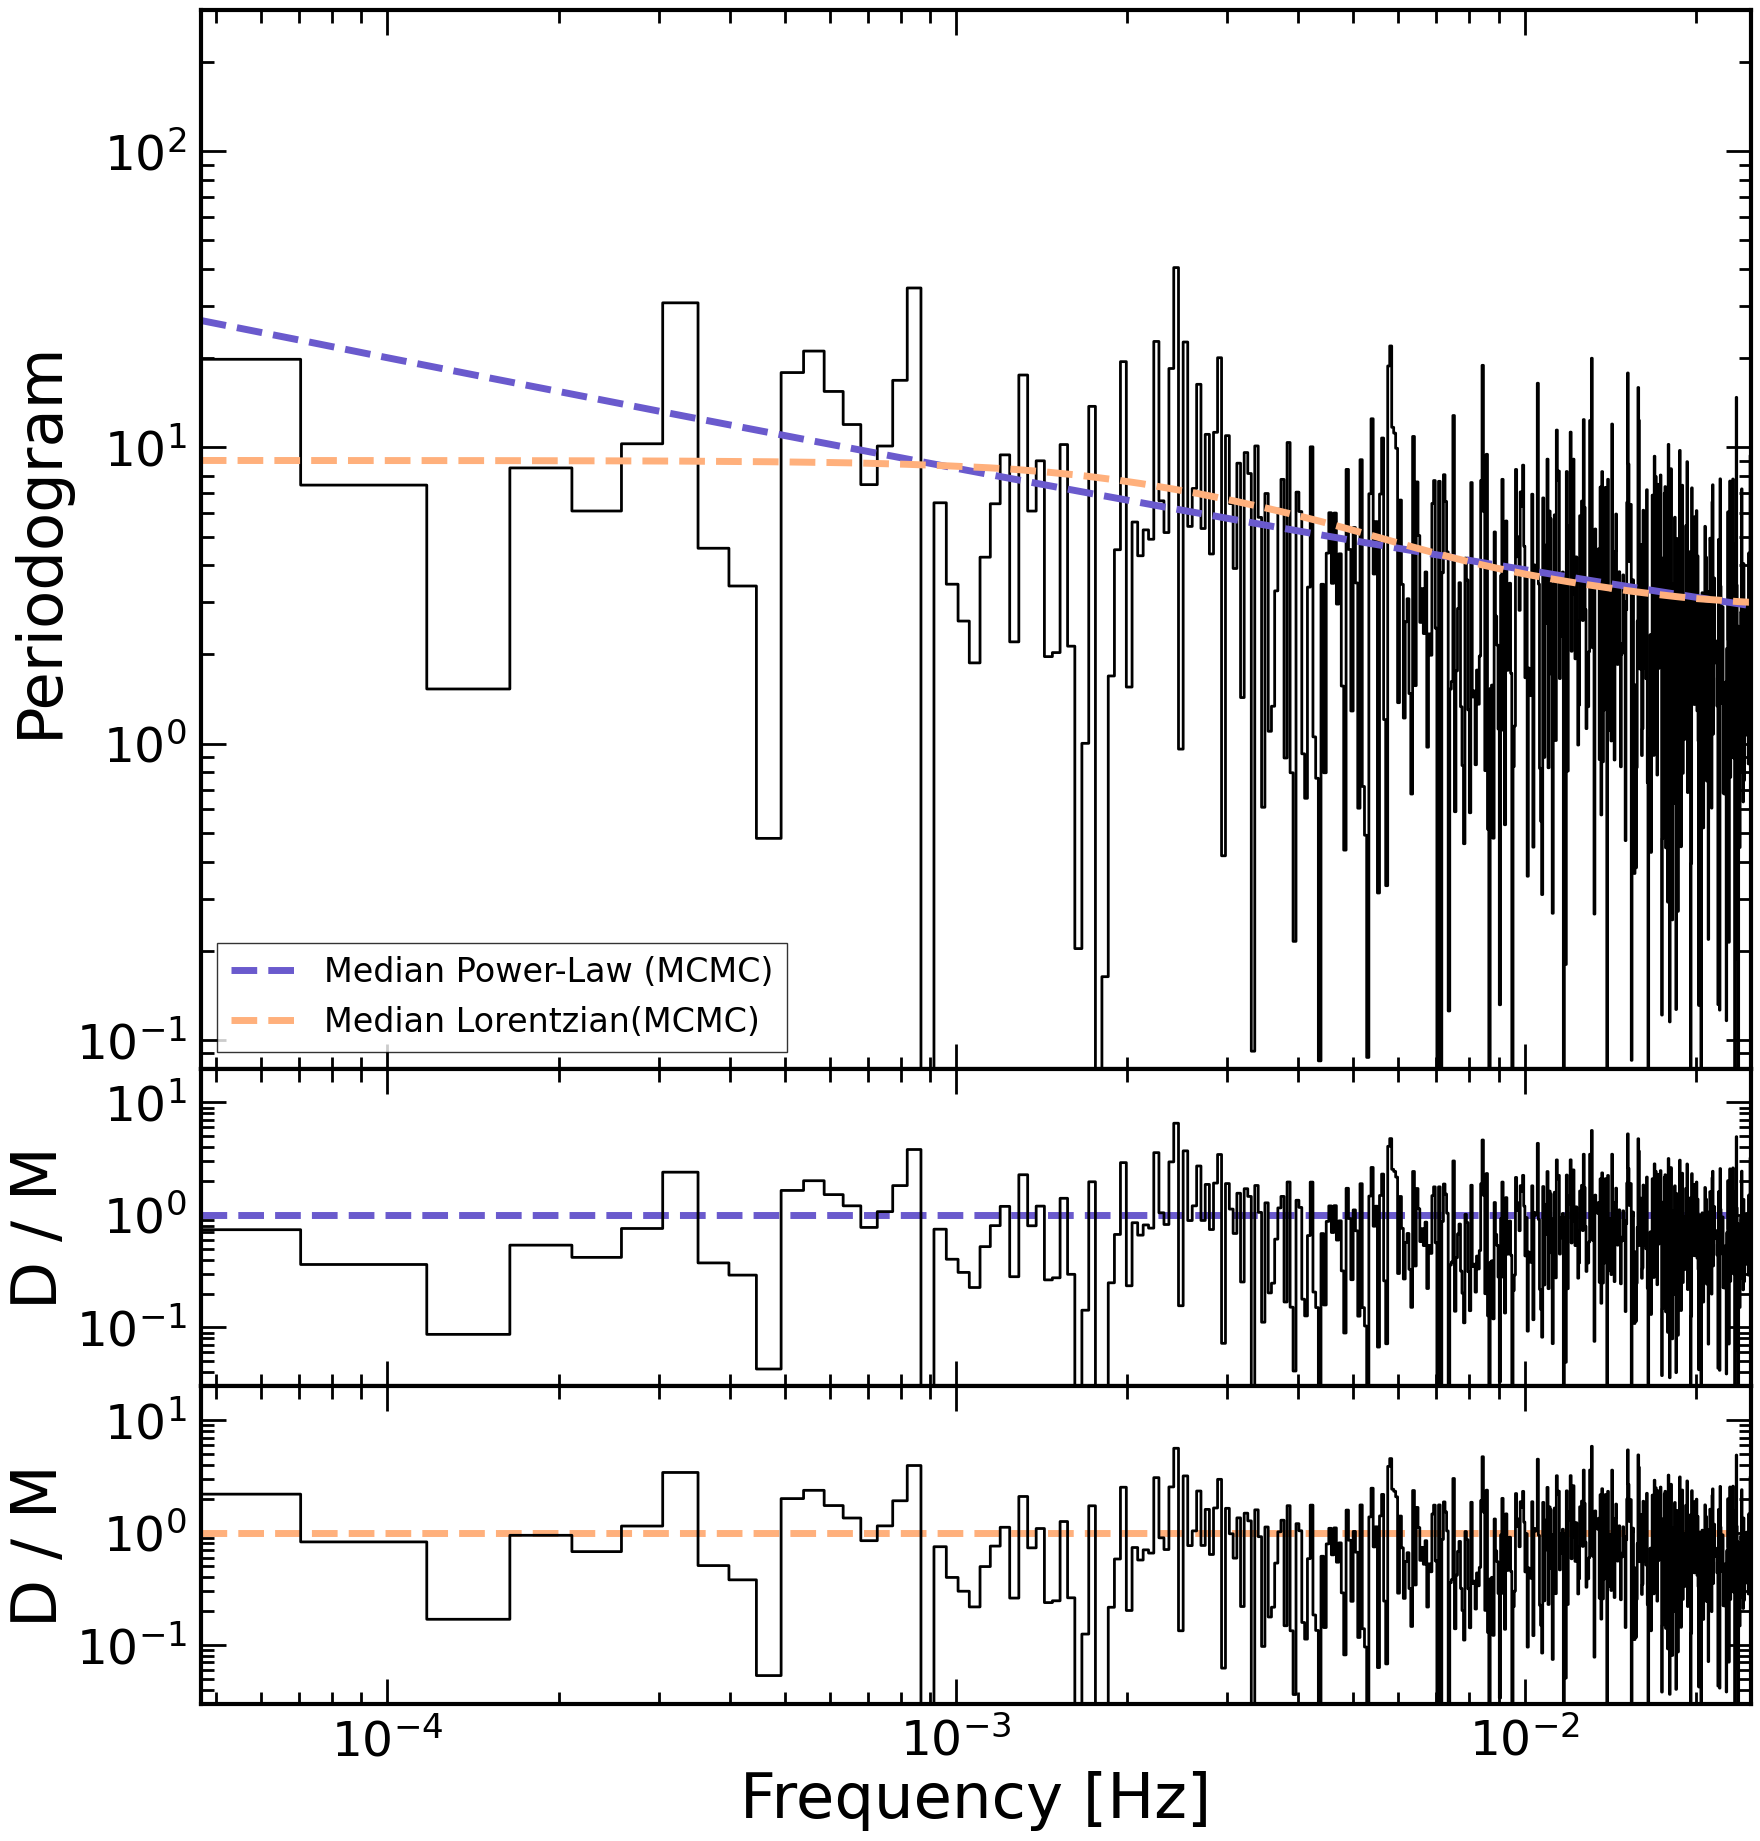

In [6]:
use_obs = np.array(['0915390701', '0931791401', '0932392001', '0932392101'])
emin = 2.
emax = 10.
tbin = 20
n = 0

# set up arrays to save data into 
qpo_freq = np.zeros((len(use_obs), 3))
Q = np.zeros((len(use_obs), 3))
rms = np.zeros((len(use_obs), 3))
char_freq = np.zeros((len(use_obs), 3))

# loop over all observations
for i, obs in enumerate(use_obs):
    MLE_and_MCMC(obs, data_path, emin, emax, tbin=tbin, n=0, nsteps=55000, nburn=5000, use_model='all')

## Multiple Observations, fit simultaneously

Below we perform the same analysis but with simultaneous fitting for multiple observations, which is applicable for the July/August 2022 data for 1ES 1927+654 because we have 4 short observations in the span of a week. For this, we fit the broadband noise models simultaneously, with all of the parameters tied across all observations. To simulate the light curves, we have simulate one light curve per observation, matching each observation's observed properties. 

### Minor chane to the log likelihood function, so that it properly accounts for all of the observations

In [8]:
def log_likelihood_multi(theta, fs, ys, model):
    """
    Compute the total log likelihood over multiple datasets.

    :param theta: Model parameters.
    :param fs: List of arrays, each containing frequency values for a dataset.
    :param ys: List of arrays, each containing power values for a dataset.
    :param model: The model to use ('powerlaw', 'broken_powerlaw', or 'lorentzian').
    :return: Total log likelihood summed over all datasets.
    """
    total_log_likelihood = 0.0
    for f, y in zip(fs, ys):
        if model == 'powerlaw':
            N0, b, c = theta
            model_y = powerlaw(f, N0, b, c)
        elif model == 'lorentzian':
            R, delta, c = theta
            model_y = lorentzian(f, R, delta, c)
        total_log_likelihood += np.sum((y / model_y) + np.log(model_y))
    return total_log_likelihood  # note that this is really the negative log likelihood (i.e. maximize this fn for MLE)

def log_probability_multi(theta, fs, ys, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood_multi(theta, fs, ys, model)

### Set up maximum likelihood and then initialize an MCMC based on those results

In [13]:
def MLE_and_MCMC_multi(name, obs, data_path, emin, emax, tbin=20, n=0, nwalkers=32, use_model='all', nsteps=5500, nburn=500):

    # first grab the data and create lists of frequencies and powers
    # still need the unbinned data for fitting
    freq = []
    power = []
    f_min = []
    f_max = []
    for i,obsid in enumerate(obs):
        _, _, _, freq_tmp, power_tmp, _, _, f_min_tmp, f_max_tmp, _, _ = make_psd(obsid, data_path, emin, emax, tbin, n=0)
        freq.append(freq_tmp)
        power.append(power_tmp)
        f_min.append(f_min_tmp)
        f_max.append(f_max_tmp)
    min_f = min(f_min)
    max_f = max(f_max)
    grid = np.linspace(min_f, max_f, 1000)

    # first maximize likelihood - power law
    if use_model == 'powerlaw' or use_model == 'all':
        ndim_pl = 3
        initial_guess_pl = [1e-4, 2, 1]
        result_pl = opt.minimize(log_likelihood_multi, initial_guess_pl, args=(freq, power, 'powerlaw'),
                                bounds=((1e-8,1e4),(-2,2),(1e-2,1e2)))
        maxlike_pl = result_pl.x
        p0_pl = maxlike_pl * (1 + 1e-3 * np.random.randn(nwalkers, ndim_pl))

    # first maximize likelihood - lorentzian
    if use_model == 'lorentzian' or use_model == 'all':
        ndim_lor = 3
        initial_guess_lor = [5e-1, 1e-3, 1]
        result_lor = opt.minimize(log_likelihood_multi, initial_guess_lor, args=(freq, power, 'lorentzian'),
                                  bounds=((0,100),(1e-6,1),(1e-4,100)))
        maxlike_lor = result_lor.x
        p0_lor = maxlike_lor * (1 + 1e-3 * np.random.randn(nwalkers, ndim_lor))

    # plot each of the observations
    if use_model == 'all':

        fig, axs = plt.subplots(figsize=(15*len(obs),22), nrows=3, ncols=len(obs), gridspec_kw={'hspace':0, 'height_ratios':[1,0.3,0.3]})

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]
            fmin = f_min[j]
            fmax = f_max[j]

            ax = axs[0,j]
            ax.step(f, p, color='k', lw=2, where='mid')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(8e-2,3e2)
            ax = axs[1,j]
            ax.axhline(1, color='xkcd:peach', ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)
            ax = axs[2,j]
            ax.axhline(1, color='slateblue', ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)

    if use_model == 'powerlaw' or use_model == 'lorentzian':

        if use_model == 'powerlaw':
            use_color = 'xkcd:peach'
        if use_model == 'lorentzian':
            use_color = 'slateblue'

        fig, axs = plt.subplots(figsize=(15*len(obs),14), nrows=2, ncols=len(obs), gridspec_kw={'hspace':0, 'height_ratios':[1,0.3]})

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]
            fmin = f_min[j]
            fmax = f_max[j]

            ax = axs[0,j]
            ax.step(f, p, color='k', lw=2, where='mid')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(8e-2,3e2)
            ax = axs[1,j]
            ax.axhline(1, color=use_color, ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)

    # grab n_rand samples and pick out the median fit
    n_rand = 100
    if use_model == 'powerlaw' or use_model == 'all':

        fname = mcmc_path+'broadband_'+name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_pl = backend.get_chain(discard=nburn, flat=True)
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_pl)
            sampler_pl = emcee.EnsembleSampler(nwalkers, ndim_pl, log_probability_multi, args=(freq, power, 'powerlaw'), backend=backend)
            sampler_pl.run_mcmc(p0_pl, nsteps, progress=True)
            samples_pl = sampler_pl.get_chain(discard=nburn, flat=True)

        lab = [r"$\log N_0$", r"$\alpha$", r"$c$"]
        fig = corner.corner(samples_pl, labels=lab, truths=maxlike_pl, figsize=(18,18), labelpad=1)

        Rhat_max_pl = []
        QPO_freq_pl = []
        SSE_pl_tot = 0

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]

            fit_pl = np.zeros((len(grid),n_rand))
            fit_binned_pl = np.zeros((len(f),n_rand))
            for i in range(n_rand):

                use_N0, use_b, use_c = samples_pl[i,:]
                fit_pl[:,i] = powerlaw(grid, use_N0, use_b, use_c)
                fit_binned_pl[:,i] = powerlaw(f, use_N0, use_b, use_c)

            med_fit_pl = np.median(fit_pl, axis=1)
            med_fit_binned_pl = np.median(fit_binned_pl, axis=1)
            axs[0,j].plot(grid, med_fit_pl, color='xkcd:peach', lw=5, ls='--', label='Power-Law (MCMC)')
            axs[1,j].step(f, p / med_fit_binned_pl, color='k', lw=2, where='mid')

            # find T_R
            Rhat_pl = 2 * p / med_fit_binned_pl #null(bin_midpoints, *popt_null)
            Rhat_max_pl.append(np.max(Rhat_pl))
            QPO_freq_pl.append(f[np.argmax(Rhat_pl)])

            # find T_SSE
            SSE_pl = np.sum(((p - med_fit_binned_pl) / med_fit_binned_pl)**2)
            SSE_pl_tot += SSE_pl

        print('R (power-law): ', Rhat_max_pl)
        print('QPO freq. (power-law): ', QPO_freq_pl)
        print('SSE (power-law): ', SSE_pl_tot)

    if use_model == 'lorentzian' or use_model == 'all':

        fname = mcmc_path+'broadband_'+name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_lor = backend.get_chain(discard=nburn, flat=True)
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_lor)
            sampler_lor = emcee.EnsembleSampler(nwalkers, ndim_lor, log_probability_multi, args=(freq, power, 'lorentzian'), backend=backend)
            sampler_lor.run_mcmc(p0_lor, nsteps, progress=True)
            samples_lor = sampler_lor.get_chain(discard=nburn, flat=True)

        lab = [r"$R$", r"$\Delta$", r"$c$"]
        fig = corner.corner(samples_lor, labels=lab, truths=maxlike_lor, figsize=(18,18), labelpad=1)

        Rhat_max_lor = []
        QPO_freq_lor = []
        SSE_lor_tot = 0

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]

            fit_lor = np.zeros((len(grid),n_rand))
            fit_binned_lor = np.zeros((len(f),n_rand))
            for i in range(n_rand):
                use_R, use_delta, use_c = samples_lor[i,:]
                fit_lor[:,i] = lorentzian(grid, use_R, use_delta, use_c)
                fit_binned_lor[:,i] = lorentzian(f, use_R, use_delta, use_c)
            med_fit_lor = np.median(fit_lor, axis=1)
            med_fit_binned_lor = np.median(fit_binned_lor, axis=1)
            axs[0,j].plot(grid, med_fit_lor, color='slateblue', lw=5, ls='--', label='Lorentzian (MCMC)')
            if use_model == 'all':
                axs[2,j].step(f, p / med_fit_binned_lor, color='k', lw=2, where='mid')
            else:
                axs[1,j].step(f, p / med_fit_binned_lor, color='k', lw=2, where='mid')

            # find T_R
            Rhat_lor = 2 * p / med_fit_binned_lor 
            Rhat_max_lor.append(np.max(Rhat_lor))
            QPO_freq_lor.append(f[np.argmax(Rhat_lor)])

            # find T_SSE
            SSE_lor = np.sum(((p - med_fit_binned_lor) / med_fit_binned_lor)**2)
            SSE_lor_tot += SSE_lor

        print('R (lorentzian): ', Rhat_max_lor)
        print('QPO freq. (lorentzian): ', QPO_freq_lor)
        print('SSE (lorentzian): ', SSE_lor_tot)

    axs[0,0].legend(fontsize=24, loc='lower left')

    # for LRT + saving all the samples
    if use_model == 'all':

        # power law values to save
        save_N0_pl = samples_pl[:,0]
        save_b_pl = samples_pl[:,1]
        save_c_pl = samples_pl[:,2]

        # lorentzian values to save
        save_R_lor = samples_lor[:,0]
        save_delta_lor = samples_lor[:,1]
        save_c_lor = samples_lor[:,2]

        return save_N0_pl, save_b_pl, save_c_pl, Rhat_max_pl, QPO_freq_pl, SSE_pl_tot, save_R_lor, save_delta_lor, save_c_lor, Rhat_max_lor, QPO_freq_lor, SSE_lor_tot
    
    elif use_model == 'powerlaw':
        return Rhat_max_pl, QPO_freq_pl, SSE_pl_tot
    elif use_model == 'lorentzian':
        return Rhat_max_lor, QPO_freq_lor, SSE_lor_tot

R (power-law):  [10.778506618545537, 11.219905087161804, 16.626687195097826, 12.274385749805928]
QPO freq. (power-law):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (power-law):  1654.4854725313887
R (lorentzian):  [11.224602665951693, 11.059248430556748, 16.287500011118084, 13.293035968025983]
QPO freq. (lorentzian):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (lorentzian):  1611.86440546537


(array([0.22983829, 0.64025613, 0.99265737, ..., 0.57692471, 0.7133162 ,
        0.35818222]),
 array([0.56187424, 0.43410425, 0.38233396, ..., 0.44583098, 0.39824841,
        0.48962753]),
 array([2.60498817, 0.73074267, 0.13925626, ..., 1.00654222, 1.23429   ,
        1.95535384]),
 [10.778506618545537,
  11.219905087161804,
  16.626687195097826,
  12.274385749805928],
 [0.013642297650130548,
  0.018144690781796965,
  0.018648018648018648,
  0.010344827586206896],
 1654.4854725313887,
 array([0.18475335, 0.22209118, 0.2241031 , ..., 0.2305541 , 0.22366351,
        0.23687506]),
 array([0.00177039, 0.00263219, 0.00247135, ..., 0.00322219, 0.00233312,
        0.00255827]),
 array([4.82424169, 4.08726312, 4.2272175 , ..., 4.12060494, 4.577999  ,
        4.3134437 ]),
 [11.224602665951693,
  11.059248430556748,
  16.287500011118084,
  13.293035968025983],
 [0.013642297650130548,
  0.018144690781796965,
  0.018648018648018648,
  0.010344827586206896],
 1611.86440546537)

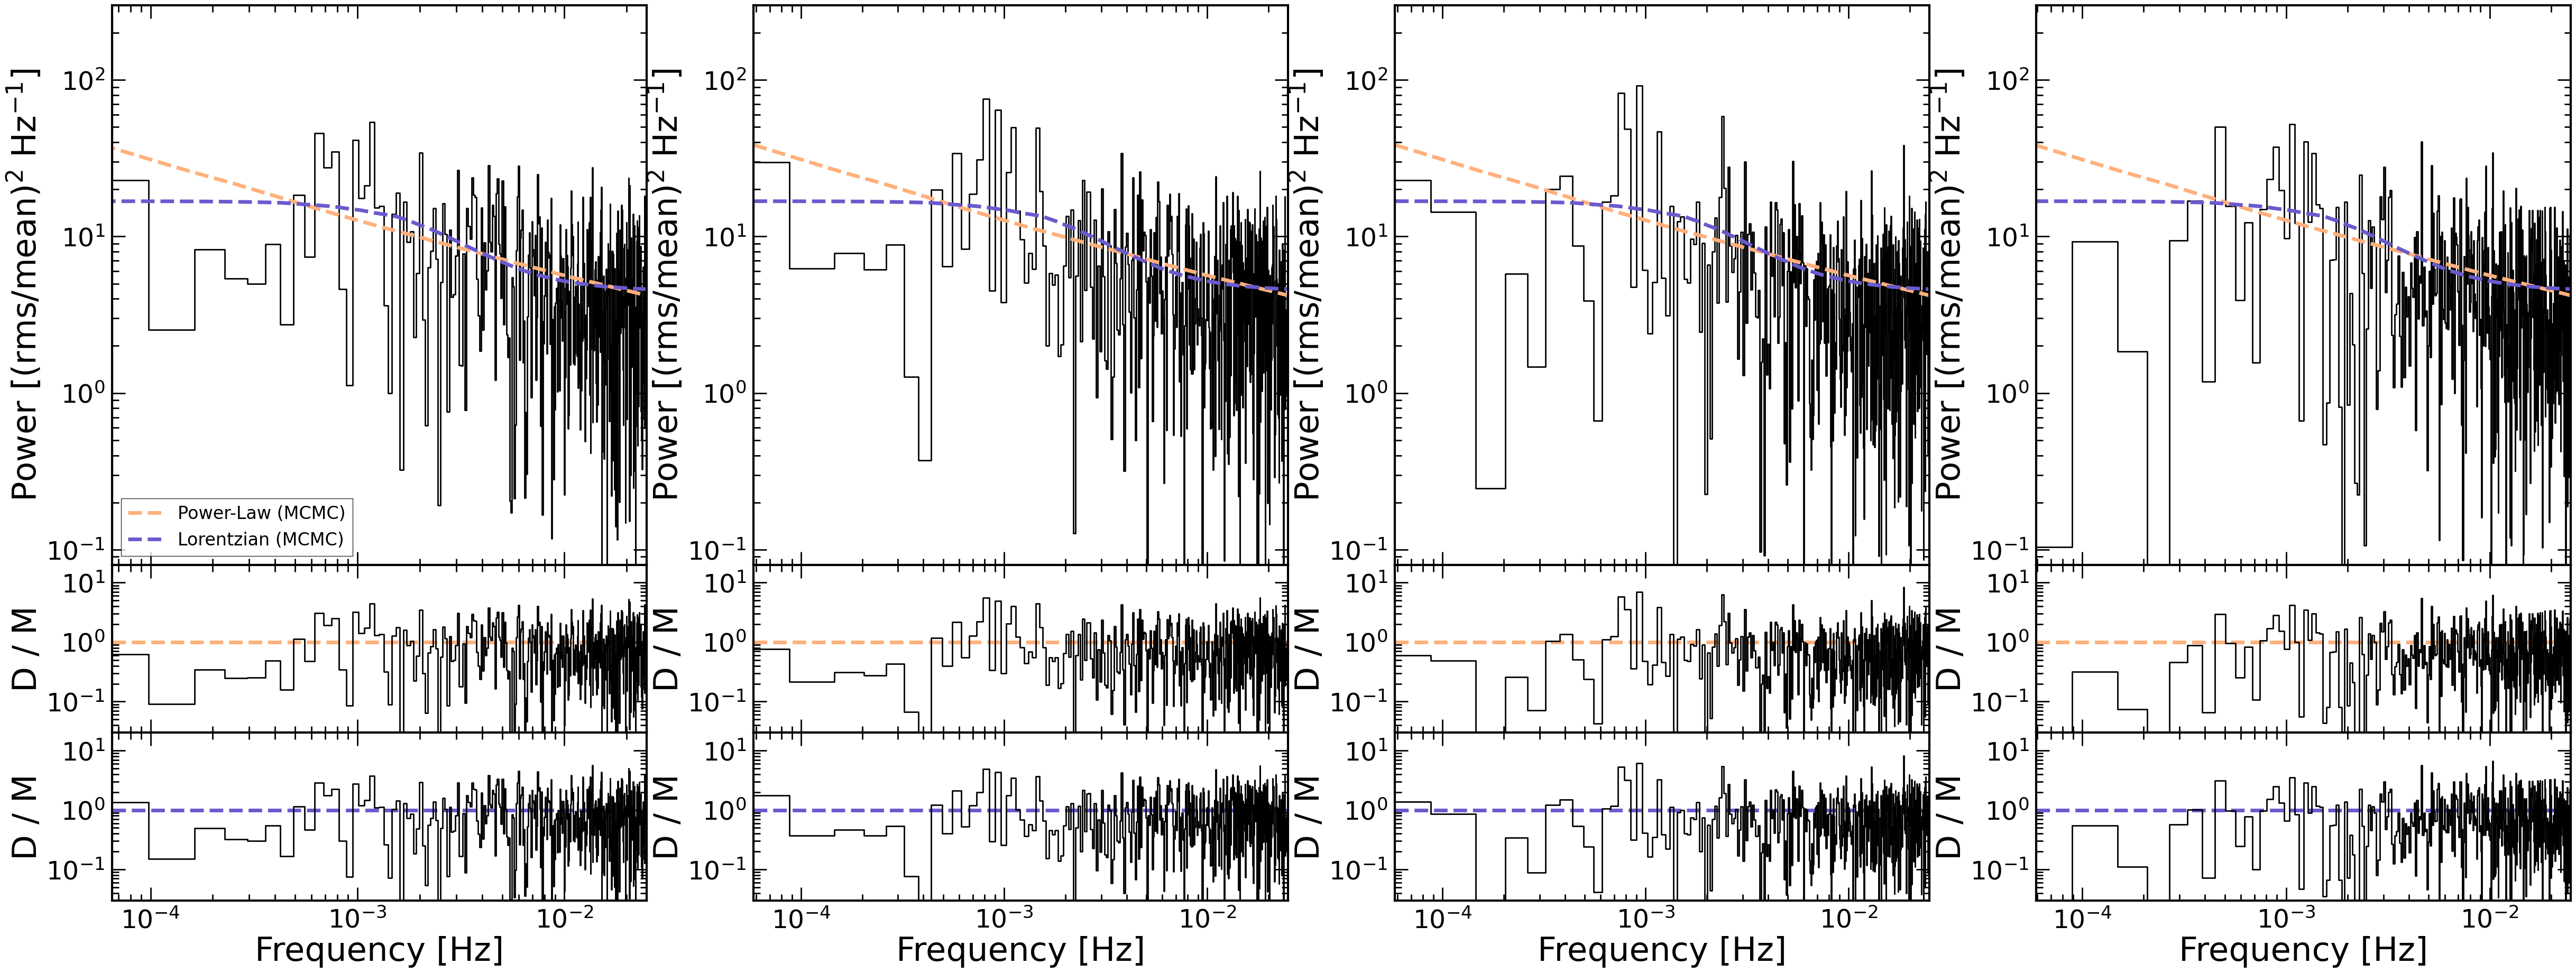

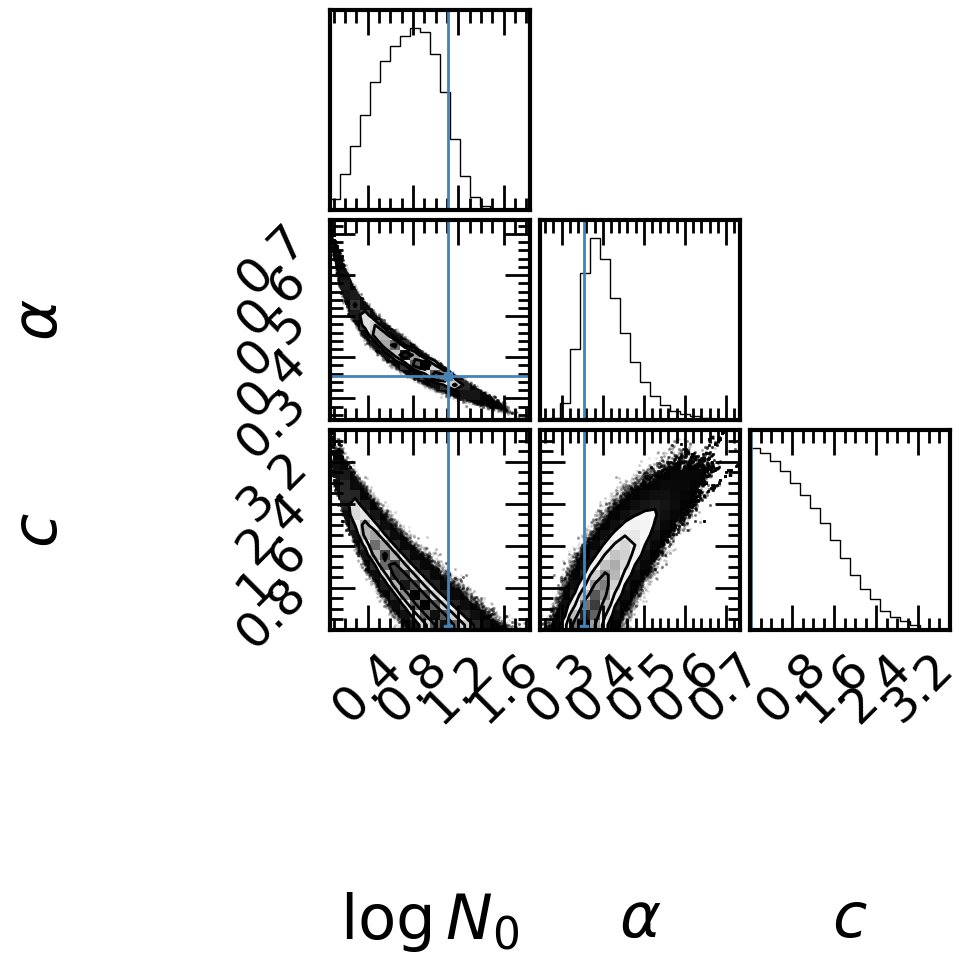

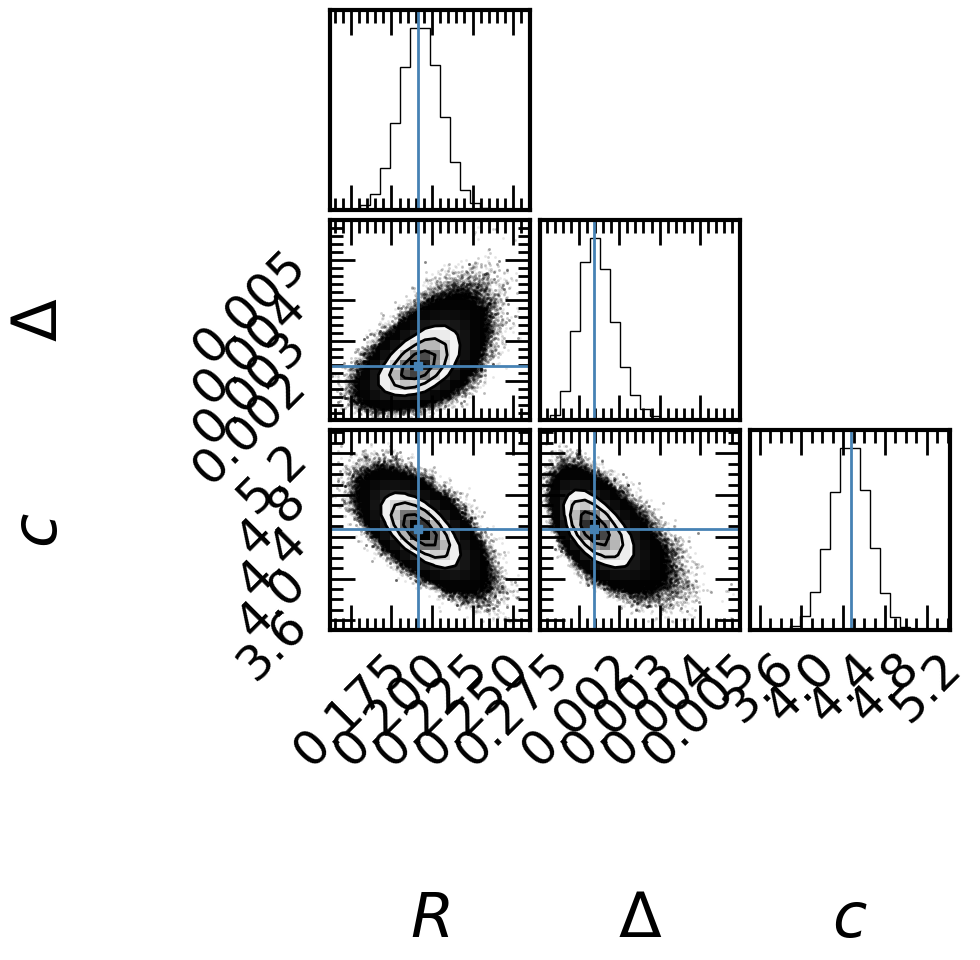

In [14]:
obs_aug2022 = np.array(['0902590201', '0902590301', '0902590401', '0902590501'])
MLE_and_MCMC_multi('Aug2022', obs_aug2022, data_path, 2., 10., tbin=20, n=0, nsteps=55000, nburn=5000, use_model='all')